In [1]:
from bound_probs.utils.data import get_dataset
from bound_probs.cogmodels import build_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = get_dataset()

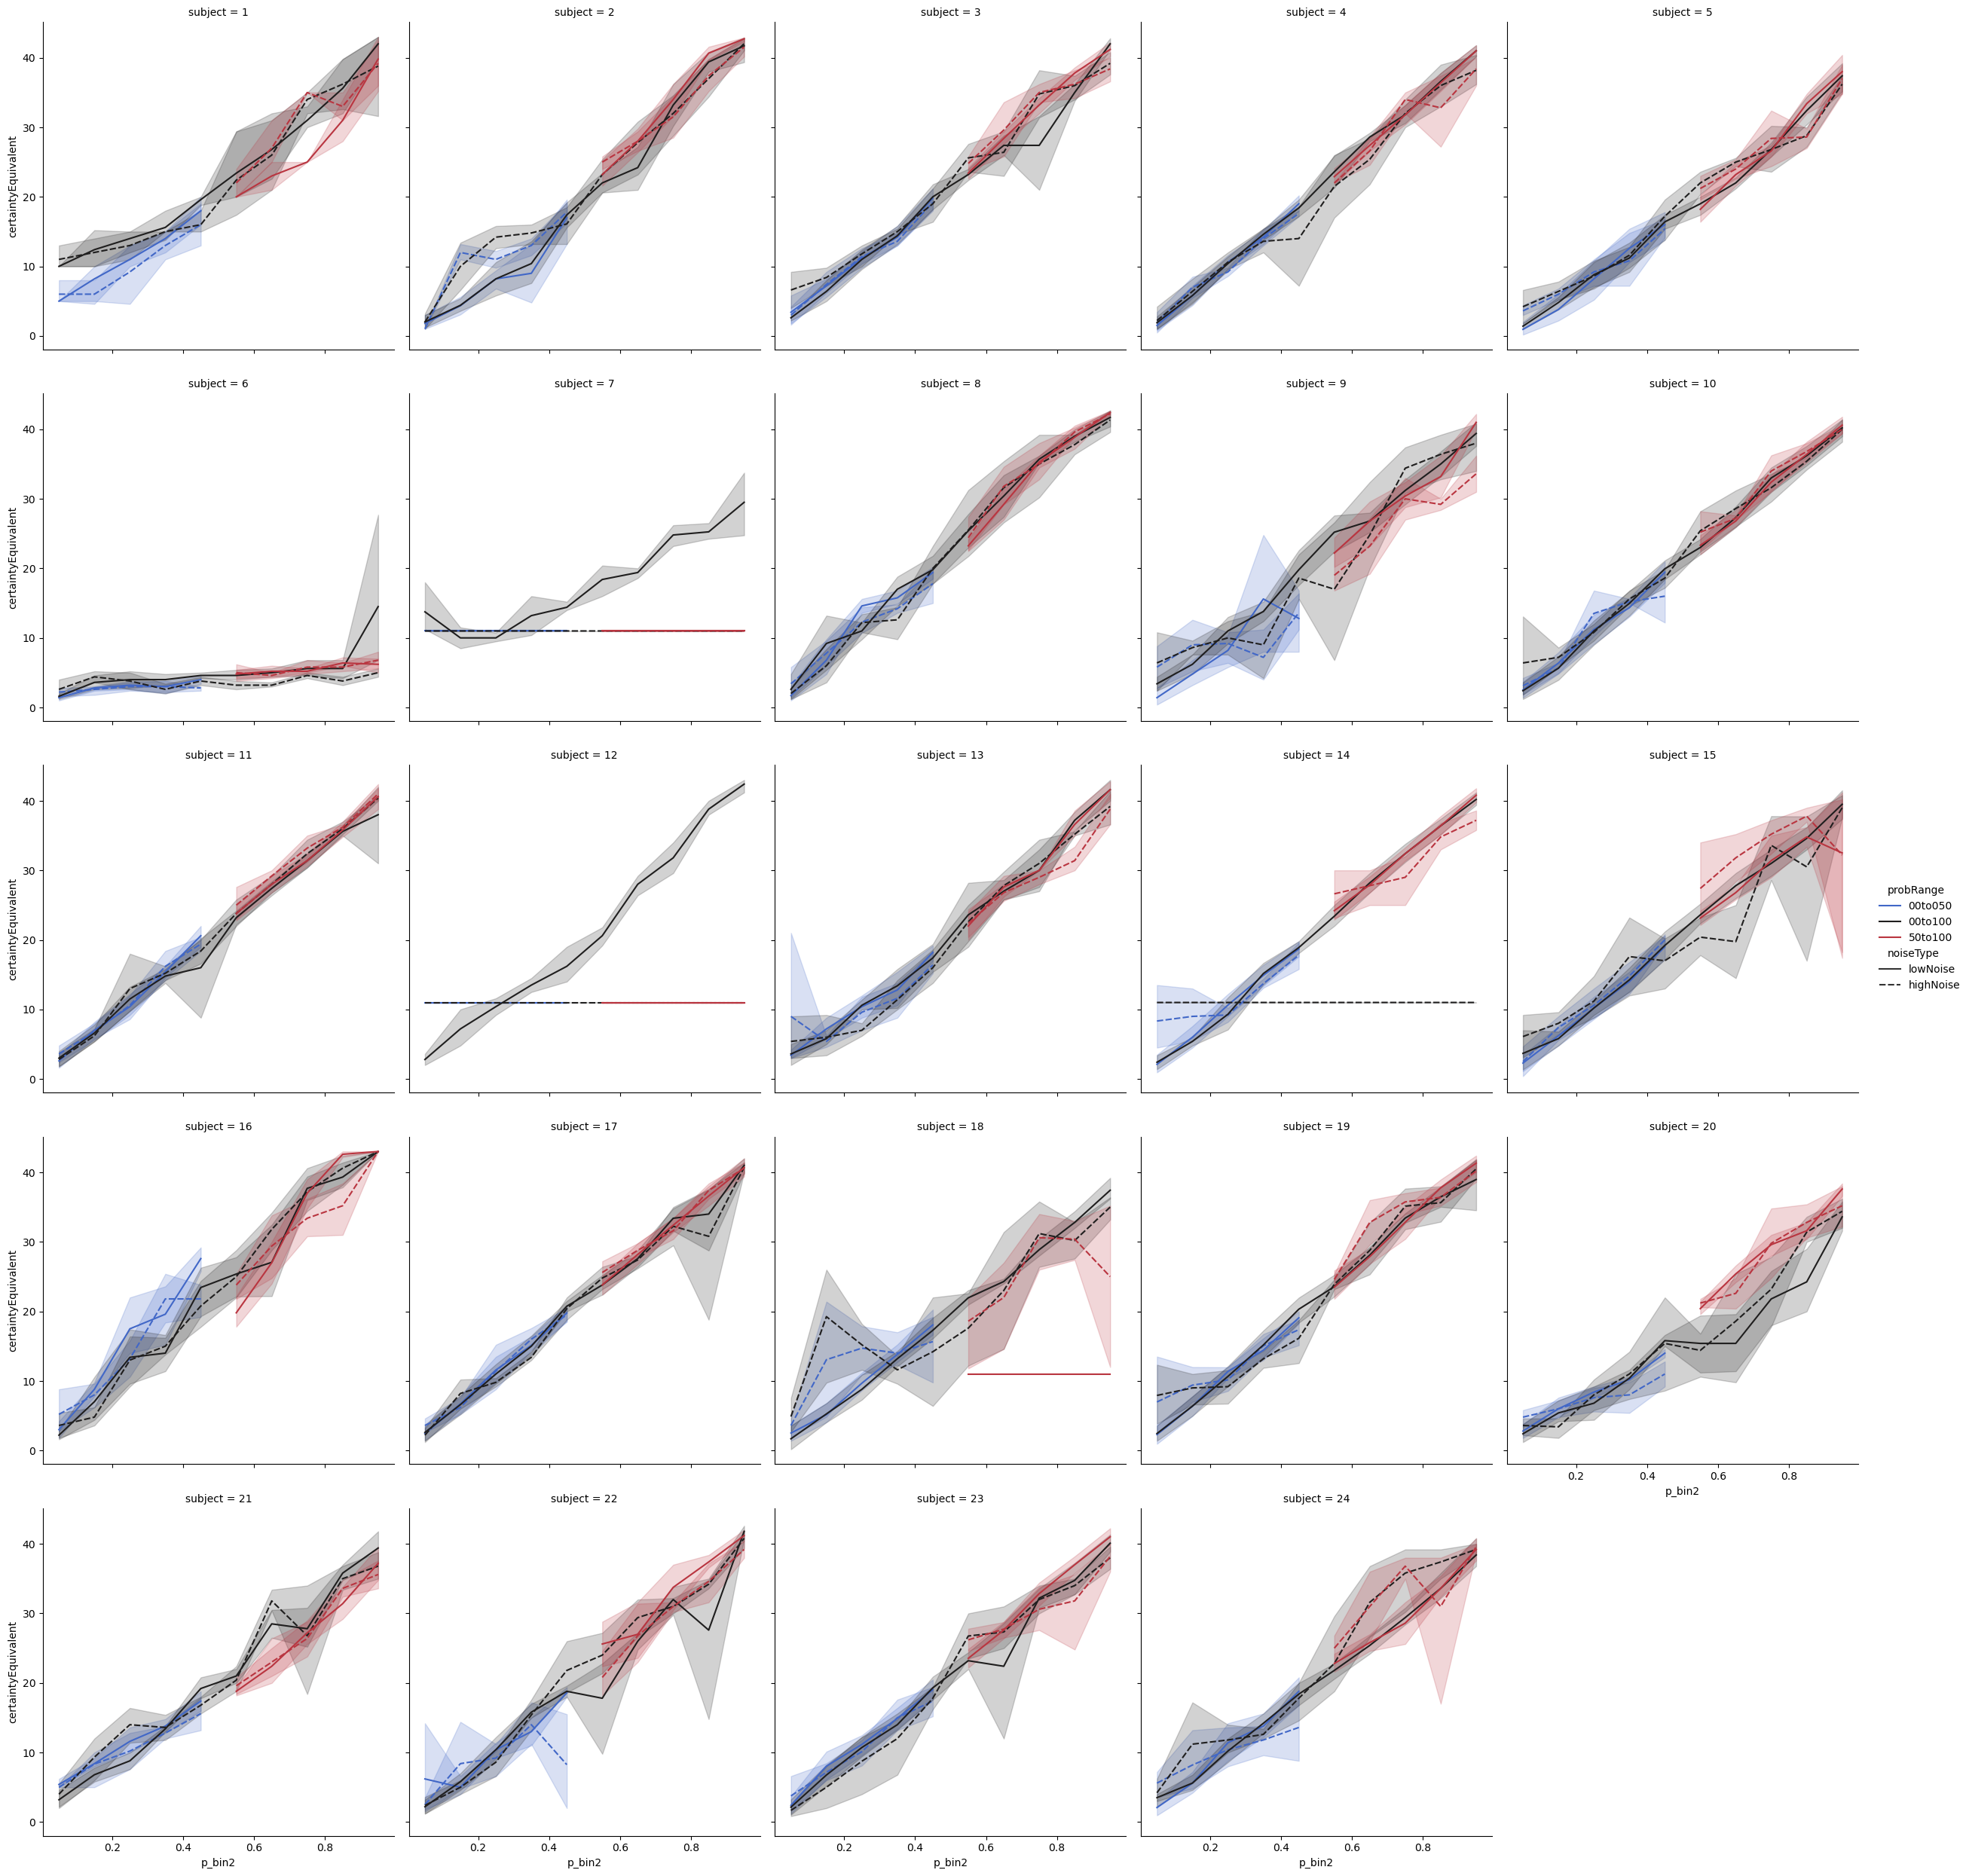

In [6]:
palette = sns.color_palette('icefire', 3)

sns.relplot(df.reset_index(), col='subject', hue='probRange', style='noiseType', col_wrap=5,
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin2', y='certaintyEquivalent', kind='line')

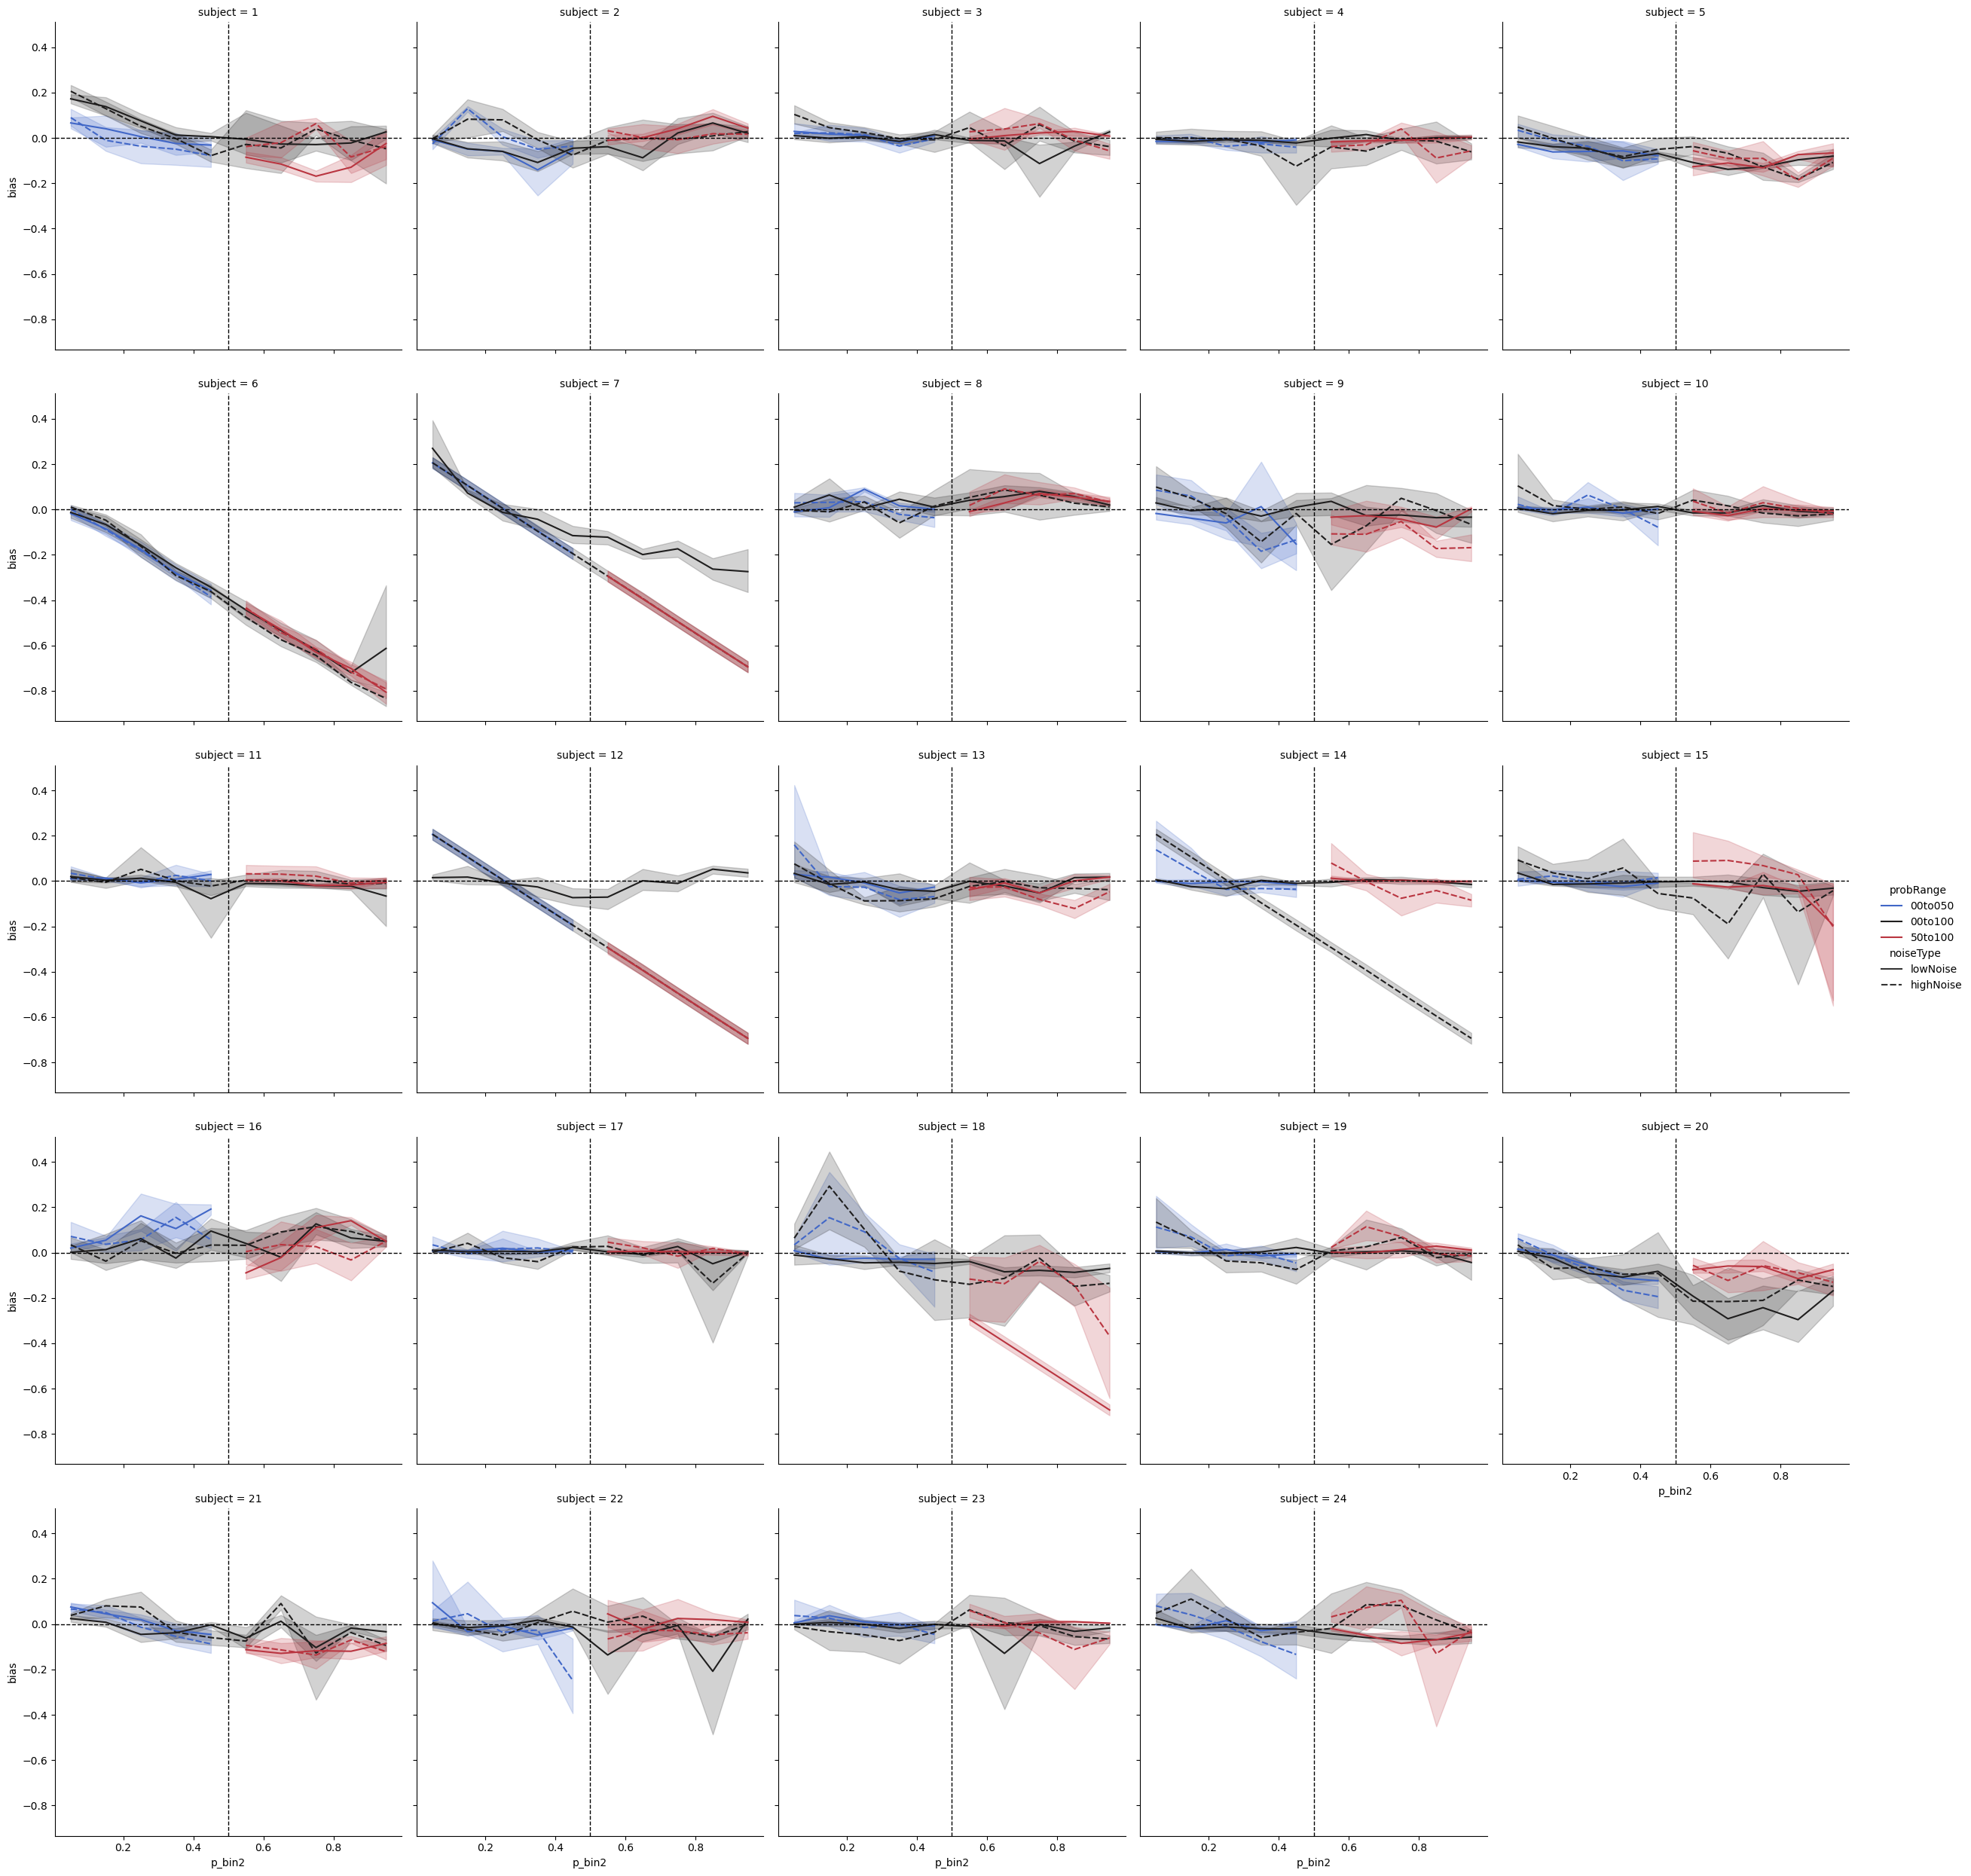

In [10]:
palette = sns.color_palette('icefire', 3)

g = sns.relplot(df.reset_index(), col='subject', hue='probRange', style='noiseType', col_wrap=5,
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin2', y='bias', kind='line')

g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--', linewidth=1))
g.map(lambda *args, **kwargs: plt.axvline(0.5, color='k', linestyle='--', linewidth=1))


In [13]:
df.groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43027/2800266890.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean()


trialStartTime  \
subject p_bin2             probRange noiseType                   
1       0.05               00to050   highNoise       96.651019   
                                     lowNoise       140.350053   
                           00to100   highNoise      223.155110   
                                     lowNoise       351.953177   
                           50to100   highNoise             NaN   
...                                                        ...   
24      0.9500000000000002 00to050   lowNoise              NaN   
                           00to100   highNoise      317.449346   
                                     lowNoise       218.553605   
                           50to100   highNoise      133.454914   
                                     lowNoise       119.650435   

                                                presentedProb_1  \
subject p_bin2             probRange noiseType                    
1       0.05               00to050   highNoise            259.2   
                                     lowNoise               5.0   
                           00to100   highNoise            259.2   
                                     lowNoise               5.0   
                           50to100   highNoise              NaN   
...                                                         ...   
24      0.9500000000000002 00to050   lowNoise               NaN   
                           00to100   highNoise           6100.0   
                                     lowNoise              95.0   
                           50to100   highNoise           6100.0   
                                     lowNoise              95.0   

                                                presentedProb_2  \
subject p_bin2             probRange noiseType                    
1       0.05               00to050   highNoise           5790.6   
                                     lowNoise             100.0   
                           00to100   highNoise           5790.6   
                                     lowNoise             100.0   
                           50to100   highNoise              NaN   
...                                                         ...   
24      0.9500000000000002 00to050   lowNoise               NaN   
                           00to100   highNoise           6419.2   
                                     lowNoise             100.0   
                           50to100   highNoise           6419.2   
                                     lowNoise             100.0   

                                                certaintyEquivalent  \
subject p_bin2             probRange noiseType                        
1       0.05               00to050   highNoise                  6.0   
                                     lowNoise                   5.0   
                           00to100   highNoise                 11.0   
                                     lowNoise                  10.0   
                           50to100   highNoise                  NaN   
...                                                             ...   
24      0.9500000000000002 00to050   lowNoise                   NaN   
                           00to100   highNoise                 39.2   
                                     lowNoise                  38.4   
                           50to100   highNoise                 39.6   
                                     lowNoise                  39.2   

                                                responseTime  riskyValue  \
subject p_bin2             probRange noiseType                             
1       0.05               00to050   highNoise     11.000001        43.0   
                                     lowNoise      11.000001        43.0   
                           00to100   highNoise     11.000001        43.0   
                                     lowNoise      11.000004        43.0   
                           50to100   highNoise           NaN     

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43027/277498870.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(df.groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType',


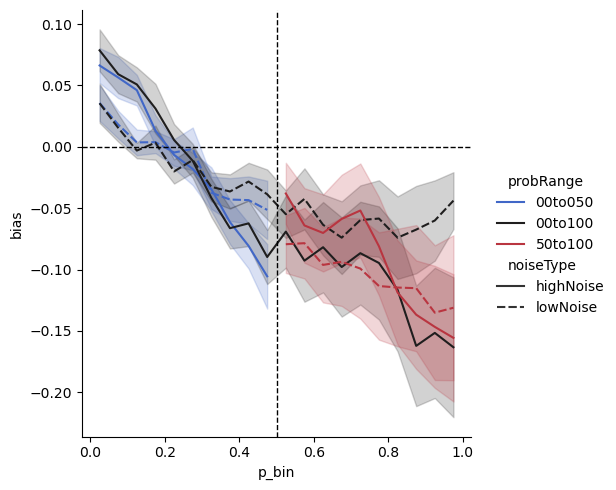

In [18]:
palette = sns.color_palette('icefire', 3)

g = sns.relplot(df.groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType', 
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin', y='bias', kind='line',
            errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--', linewidth=1))
g.map(lambda *args, **kwargs: plt.axvline(0.5, color='k', linestyle='--', linewidth=1))


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43027/979708363.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(df.groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType',


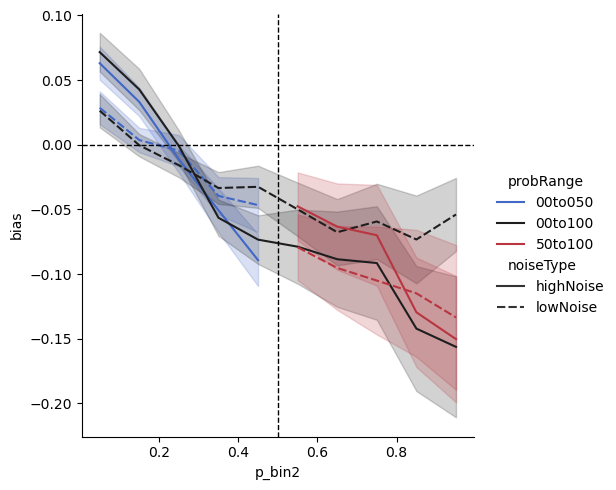

In [17]:
palette = sns.color_palette('icefire', 3)

g = sns.relplot(df.groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType', 
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin2', y='bias', kind='line',
            errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--', linewidth=1))
g.map(lambda *args, **kwargs: plt.axvline(0.5, color='k', linestyle='--', linewidth=1))


Text(0.5, 0.98, 'Narrow ranges - full range')

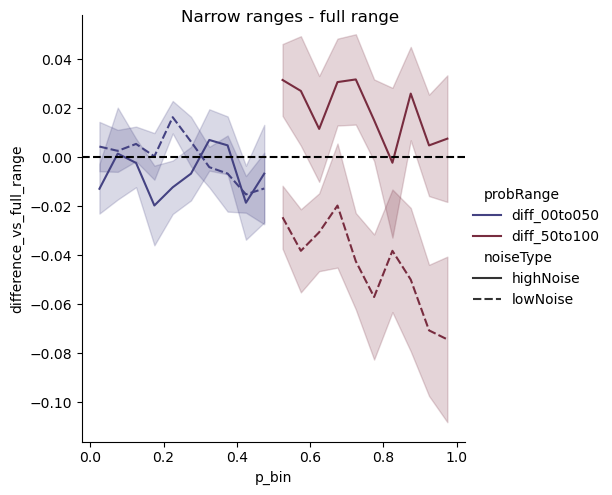

In [50]:
tmp = df.groupby(['subject', 'probRange', 'noiseType', 'p', 'p_bin'])[['bias']].mean()

tmp = tmp.unstack('probRange')['bias']

tmp['diff_00to050'] = tmp['00to050'] - tmp['00to100']
tmp['diff_50to100'] = tmp['50to100'] - tmp['00to100']

tmp = tmp[['diff_00to050', 'diff_50to100']].stack().to_frame('difference_vs_full_range')

g = sns.relplot(tmp.reset_index(), hue='probRange', style='noiseType', x='p_bin', y='difference_vs_full_range', kind='line', palette=sns.color_palette('icefire', 2), errorbar='se')
plt.axhline(0.0, c='k', ls='--')

plt.suptitle('Narrow ranges - full range')

# Without problematic subjects

In [52]:
problematic_subjects = [6,7,12,18]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43027/788878765.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(df.drop(problematic_subjects, level='subject').groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType',


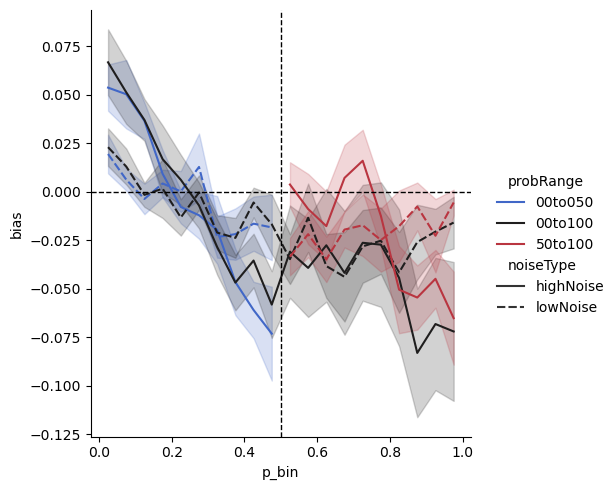

In [56]:
palette = sns.color_palette('icefire', 3)

g = sns.relplot(df.drop(problematic_subjects, level='subject').groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType', 
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin', y='bias', kind='line',
            errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--', linewidth=1))
g.map(lambda *args, **kwargs: plt.axvline(0.5, color='k', linestyle='--', linewidth=1))


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43027/2289659889.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(df.drop(problematic_subjects, level='subject').groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType',


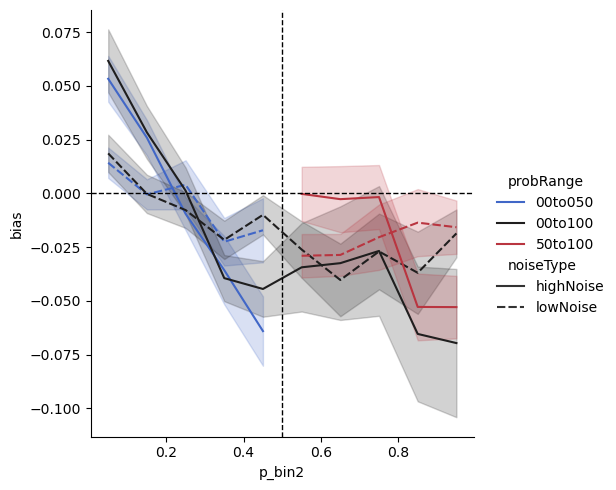

In [57]:
palette = sns.color_palette('icefire', 3)

g = sns.relplot(df.drop(problematic_subjects, level='subject').groupby(['subject', 'p_bin2', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange', style='noiseType', 
            hue_order=('00to050', '00to100', '50to100'),
            palette=palette, x='p_bin2', y='bias', kind='line',
            errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--', linewidth=1))
g.map(lambda *args, **kwargs: plt.axvline(0.5, color='k', linestyle='--', linewidth=1))


Text(0.5, 0.98, 'Narrow ranges - full range')

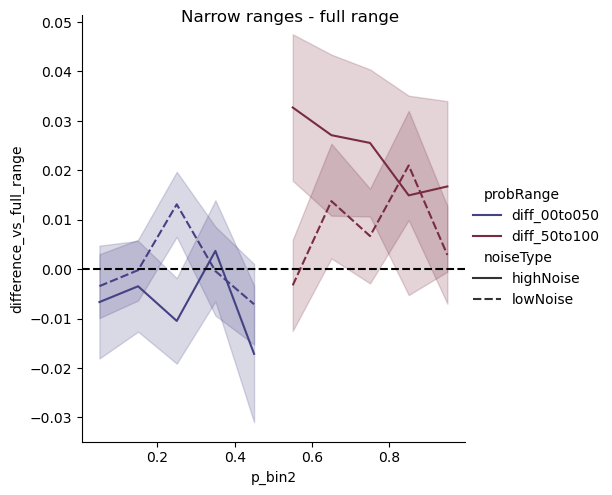

In [60]:
tmp = df.drop(problematic_subjects, level='subject').groupby(['subject', 'probRange', 'noiseType', 'p', 'p_bin2'])[['bias']].mean()

tmp = tmp.unstack('probRange')['bias']

tmp['diff_00to050'] = tmp['00to050'] - tmp['00to100']
tmp['diff_50to100'] = tmp['50to100'] - tmp['00to100']

tmp = tmp[['diff_00to050', 'diff_50to100']].stack().to_frame('difference_vs_full_range')

g = sns.relplot(tmp.reset_index(), hue='probRange', style='noiseType', x='p_bin2', y='difference_vs_full_range', kind='line', palette=sns.color_palette('icefire', 2), errorbar='se')
plt.axhline(0.0, c='k', ls='--')

plt.suptitle('Narrow ranges - full range')